In [ ]:
pip install opencv-python

In [ ]:
# Mount Google Drive
from google.colab import drive
import zipfile
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Install the Ultralytics YOLOv8 package
!pip install ultralytics

# Import YOLOv8 after installation
from ultralytics import YOLO

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.9/932.9 kB 15.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Define paths
zip_path = "/content/drive/MyDrive/crop_weed_detection/archive.zip"  # Update this path if needed
extract_path = '/content/crop-and-weed-detection-data-with-bounding-boxes/'
yolo_data_path = '/content/yolo_data/'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Read class names
classes_file = os.path.join(extract_path, 'classes.txt')
with open(classes_file, 'r') as file:
    class_names = [line.strip() for line in file.readlines()]

print(f"Classes: {class_names}")

Classes: ['crop', 'weed']


In [ ]:
# Create YOLO dataset directory structure
os.makedirs(os.path.join(yolo_data_path, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_path, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_path, 'images', 'test'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_path, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_path, 'labels', 'val'), exist_ok=True)
os.makedirs(os.path.join(yolo_data_path, 'labels', 'test'), exist_ok=True)

# Source data directory
data_dir = os.path.join(extract_path, 'agri_data/data/')

# Get all image filenames
image_filenames = [os.path.splitext(filename)[0] for filename in os.listdir(data_dir) if filename.endswith('.jpeg')]
print(f"Total images: {len(image_filenames)}")

Total images: 1300


In [ ]:
# Split data into train, validation, and test sets (70%, 20%, 10%)
random.seed(42)
random.shuffle(image_filenames)

train_split = int(0.7 * len(image_filenames))
val_split = int(0.9 * len(image_filenames))

train_files = image_filenames[:train_split]
val_files = image_filenames[train_split:val_split]
test_files = image_filenames[val_split:]

print(f"Train: {len(train_files)}, Validation: {len(val_files)}, Test: {len(test_files)}")

Train: 909, Validation: 261, Test: 130


In [ ]:
# Function to convert annotation format
def convert_to_yolo_format(file_path, img_width, img_height):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        yolo_lines = []

        for line in lines:
            data = line.strip().split()
            class_idx = int(data[0])

            # Original format could be either [center_x, center_y, width, height] or [x_min, y_min, x_max, y_max]
            # Depending on your current format, you may need to adjust this conversion
            # Here we assume the format is [x_center, y_center, width, height] in normalized coordinates
            x_center = float(data[1])
            y_center = float(data[2])
            width = float(data[3])
            height = float(data[4])

            # Ensure values are in proper range (0-1)
            x_center = max(0, min(1, x_center))
            y_center = max(0, min(1, y_center))
            width = max(0, min(1, width))
            height = max(0, min(1, height))

            # Format: class_idx x_center y_center width height
            yolo_line = f"{class_idx} {x_center} {y_center} {width} {height}"
            yolo_lines.append(yolo_line)

        return yolo_lines


In [ ]:
# Process and copy training data
for dataset, file_list in [('train', train_files), ('val', val_files), ('test', test_files)]:
    for filename in file_list:
        # Copy image
        src_img_path = os.path.join(data_dir, f"{filename}.jpeg")
        dst_img_path = os.path.join(yolo_data_path, 'images', dataset, f"{filename}.jpg")

        # Get image dimensions
        img = Image.open(src_img_path)
        img_width, img_height = img.size

        # Save image in JPG format (YOLO prefers JPG)
        img.save(dst_img_path)

        # Convert and save annotation
        src_txt_path = os.path.join(data_dir, f"{filename}.txt")
        dst_txt_path = os.path.join(yolo_data_path, 'labels', dataset, f"{filename}.txt")

        if os.path.exists(src_txt_path):
            yolo_lines = convert_to_yolo_format(src_txt_path, img_width, img_height)

            with open(dst_txt_path, 'w') as f:
                for line in yolo_lines:
                    f.write(f"{line}\n")


In [ ]:
# Create YAML configuration file for YOLOv8
yaml_content = f"""
path: {yolo_data_path}
train: images/train
val: images/val
test: images/test

nc: {len(class_names)}
names: {class_names}
"""

with open(os.path.join(yolo_data_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)

print("YAML configuration created.")

YAML configuration created.


Visualizing training examples with bounding boxes:


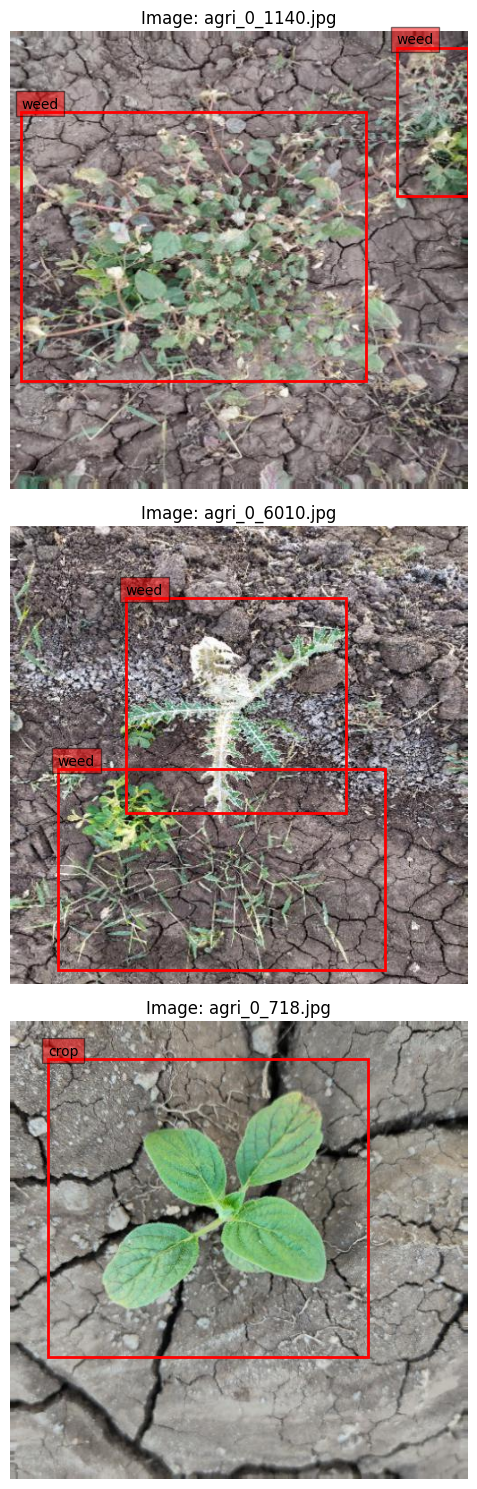

In [ ]:
# Visualize a few training examples with bounding boxes to verify
def plot_bounding_boxes(dataset_type, num_samples=3):
    image_dir = os.path.join(yolo_data_path, 'images', dataset_type)
    label_dir = os.path.join(yolo_data_path, 'labels', dataset_type)

    image_files = os.listdir(image_dir)
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 5 * num_samples))

    for i, img_file in enumerate(samples):
        img_path = os.path.join(image_dir, img_file)
        label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        # Read annotations
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            plt.subplot(num_samples, 1, i+1)
            plt.imshow(img)

            for line in lines:
                data = line.strip().split()
                class_idx = int(data[0])
                x_center = float(data[1]) * w
                y_center = float(data[2]) * h
                bbox_width = float(data[3]) * w
                bbox_height = float(data[4]) * h

                x1 = int(x_center - bbox_width / 2)
                y1 = int(y_center - bbox_height / 2)
                x2 = int(x_center + bbox_width / 2)
                y2 = int(y_center + bbox_height / 2)

                # Draw bounding box
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                                 fill=False, edgecolor='red', linewidth=2))

                # Add class label
                class_name = class_names[class_idx]
                plt.text(x1, y1-5, class_name, bbox=dict(facecolor='red', alpha=0.5))

            plt.title(f"Image: {img_file}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training examples
print("Visualizing training examples with bounding boxes:")
plot_bounding_boxes('train')

In [ ]:
# Train YOLOv8 model
# We'll use a small model (YOLOv8n) for faster training, but you can use larger models like YOLOv8s, YOLOv8m for better accuracy
model = YOLO('yolov8n.pt')  # Load a pre-trained YOLOv8 nano model

# Train the model
results = model.train(
    data=os.path.join(yolo_data_path, 'data.yaml'),
    epochs=50,  # Adjust as needed
    imgsz=640,  # Image size
    batch=16,   # Batch size (adjust based on your GPU)
    name='crop_weed_yolov8'  # Project name
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 75.2MB/s]


Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/yolo_data/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=crop_weed_yolov8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 14.1MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /content/yolo_data/labels/train... 909 images, 0 backgrounds, 0 corrupt: 100%|██████████| 909/909 [00:00<00:00, 1452.06it/s]

train: New cache created: /content/yolo_data/labels/train.cache



val: Scanning /content/yolo_data/labels/val... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<00:00, 1546.80it/s]

val: New cache created: /content/yolo_data/labels/val.cache


Plotting labels to runs/detect/crop_weed_yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/crop_weed_yolov8
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.396      2.387      1.697         33        640: 100%|██████████| 57/57 [03:09<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.51s/it]

                   all        261        395      0.518       0.39      0.374      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      1.377      1.888       1.65         45        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.25s/it]

                   all        261        395      0.476      0.494      0.458      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      1.419      1.746      1.672         46        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:23<00:00,  2.65s/it]

                   all        261        395      0.367      0.486      0.379      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G      1.441       1.62      1.705         24        640: 100%|██████████| 57/57 [03:05<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]

                   all        261        395      0.227      0.363       0.15     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      1.428      1.577      1.686         37        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.38s/it]

                   all        261        395      0.315      0.485      0.324      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      1.399      1.464      1.652         40        640: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]

                   all        261        395      0.574      0.638       0.64      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      1.384      1.369      1.625         43        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]

                   all        261        395      0.724      0.669      0.688      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      1.345      1.315      1.617         46        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.18s/it]

                   all        261        395      0.837        0.7      0.794      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G       1.35      1.331      1.606         51        640: 100%|██████████| 57/57 [03:06<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]

                   all        261        395      0.825      0.712      0.799      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      1.305      1.235      1.565         34        640: 100%|██████████| 57/57 [03:04<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]

                   all        261        395      0.547      0.626      0.586      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      1.274      1.202      1.552         46        640: 100%|██████████| 57/57 [03:04<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:19<00:00,  2.17s/it]

                   all        261        395      0.802      0.749      0.796      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      1.295      1.204      1.616         39        640: 100%|██████████| 57/57 [03:04<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.37s/it]

                   all        261        395      0.742      0.679      0.743      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      1.298      1.171      1.571         57        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.47s/it]

                   all        261        395      0.746      0.769      0.791       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      1.267      1.144      1.531         44        640: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]

                   all        261        395      0.786      0.741      0.795      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      1.232      1.135       1.54         42        640: 100%|██████████| 57/57 [03:06<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.34s/it]

                   all        261        395      0.819      0.728      0.801      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      1.259      1.095       1.53         40        640: 100%|██████████| 57/57 [03:08<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]

                   all        261        395      0.822      0.766       0.83      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      1.266      1.139      1.549         37        640: 100%|██████████| 57/57 [03:06<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.49s/it]

                   all        261        395      0.766      0.748      0.808      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.221      1.074      1.489         41        640: 100%|██████████| 57/57 [03:10<00:00,  3.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.46s/it]

                   all        261        395      0.691      0.732      0.771      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.206      1.035      1.509         46        640: 100%|██████████| 57/57 [03:06<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.33s/it]

                   all        261        395      0.781      0.783      0.826      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.219      1.068      1.491         34        640: 100%|██████████| 57/57 [03:07<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]

                   all        261        395      0.775      0.783      0.823      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.219      1.072      1.505         30        640: 100%|██████████| 57/57 [03:08<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.32s/it]

                   all        261        395      0.795       0.73      0.825      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.208      1.015      1.495         49        640: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.45s/it]

                   all        261        395      0.774      0.795      0.837      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.166     0.9935      1.468         40        640: 100%|██████████| 57/57 [03:06<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.29s/it]

                   all        261        395      0.834      0.729      0.819      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G       1.19      1.023      1.464         32        640: 100%|██████████| 57/57 [03:07<00:00,  3.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.52s/it]

                   all        261        395      0.777      0.777      0.825       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.187     0.9951       1.48         37        640: 100%|██████████| 57/57 [03:07<00:00,  3.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.41s/it]

                   all        261        395      0.807      0.762      0.831      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.165     0.9786      1.463         55        640: 100%|██████████| 57/57 [03:10<00:00,  3.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.31s/it]

                   all        261        395      0.813      0.744       0.83      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.144     0.9284       1.46         32        640: 100%|██████████| 57/57 [03:09<00:00,  3.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]

                   all        261        395      0.792      0.771      0.815      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.156     0.9567      1.464         56        640: 100%|██████████| 57/57 [03:08<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.45s/it]

                   all        261        395      0.845      0.769      0.857      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.113     0.9379      1.451         35        640: 100%|██████████| 57/57 [03:12<00:00,  3.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.51s/it]

                   all        261        395      0.842      0.788      0.849      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G       1.15     0.9647       1.43         42        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.36s/it]

                   all        261        395       0.84      0.784      0.844       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.097     0.9208      1.407         38        640: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.30s/it]

                   all        261        395       0.85      0.757      0.843      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.133     0.9079      1.434         43        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.09s/it]

                   all        261        395      0.793      0.792      0.836      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.107     0.8818      1.418         42        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.41s/it]

                   all        261        395       0.82       0.73      0.813      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.134     0.9268      1.435         53        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:20<00:00,  2.27s/it]

                   all        261        395      0.831      0.786      0.849      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.117     0.9297      1.423         47        640: 100%|██████████| 57/57 [03:04<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.07s/it]

                   all        261        395      0.811      0.789      0.848      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G       1.09     0.9066      1.411         43        640: 100%|██████████| 57/57 [03:07<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.35s/it]

                   all        261        395       0.81        0.8      0.851      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.113     0.9165      1.406         51        640: 100%|██████████| 57/57 [03:06<00:00,  3.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]

                   all        261        395      0.836      0.782      0.855      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.029     0.7945      1.387         39        640: 100%|██████████| 57/57 [03:05<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.41s/it]

                   all        261        395       0.84      0.792      0.864      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.067     0.8544      1.386         34        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]

                   all        261        395      0.851      0.783       0.86      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.087      0.861        1.4         61        640: 100%|██████████| 57/57 [03:05<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.41s/it]

                   all        261        395       0.84      0.788      0.858       0.57


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G     0.9837     0.7954       1.41         13        640: 100%|██████████| 57/57 [03:04<00:00,  3.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.39s/it]

                   all        261        395      0.828      0.796      0.856      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G     0.9592     0.7288      1.397         30        640: 100%|██████████| 57/57 [03:05<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]

                   all        261        395      0.844        0.8       0.86      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G     0.9364     0.7128      1.383         35        640: 100%|██████████| 57/57 [03:05<00:00,  3.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:23<00:00,  2.57s/it]

                   all        261        395       0.82      0.827      0.857      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G     0.9493     0.7165      1.403         24        640: 100%|██████████| 57/57 [03:08<00:00,  3.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.52s/it]

                   all        261        395      0.851      0.778      0.857      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      0.929     0.7057      1.371         23        640: 100%|██████████| 57/57 [03:06<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.47s/it]

                   all        261        395      0.863      0.779      0.872      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G     0.9136     0.6854      1.362         18        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.45s/it]

                   all        261        395      0.845      0.793      0.866      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      0.907     0.6686      1.359         19        640: 100%|██████████| 57/57 [03:05<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.44s/it]

                   all        261        395      0.871      0.785      0.862      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G     0.8858       0.65      1.352         22        640: 100%|██████████| 57/57 [03:07<00:00,  3.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.43s/it]

                   all        261        395      0.842      0.802      0.862      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      0.879     0.6513      1.334         17        640: 100%|██████████| 57/57 [03:02<00:00,  3.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:22<00:00,  2.52s/it]

                   all        261        395      0.859      0.794      0.864      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G     0.8873     0.6589      1.334         26        640: 100%|██████████| 57/57 [03:04<00:00,  3.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:21<00:00,  2.40s/it]

                   all        261        395      0.853      0.796      0.858      0.576



50 epochs completed in 2.893 hours.
Optimizer stripped from runs/detect/crop_weed_yolov8/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/crop_weed_yolov8/weights/best.pt, 6.2MB

Validating runs/detect/crop_weed_yolov8/weights/best.pt...
Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:18<00:00,  2.09s/it]


                   all        261        395      0.847      0.788      0.864      0.579
                  crop        121        214      0.785      0.786      0.865      0.596
                  weed        140        181      0.908       0.79      0.862      0.562
Speed: 1.7ms preprocess, 63.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/crop_weed_yolov8


In [ ]:
# Evaluate the model on the validation set
val_results = model.val()

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/yolo_data/labels/val.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:15<00:00,  1.09it/s]


                   all        261        395      0.847      0.788      0.864      0.579
                  crop        121        214      0.785      0.786      0.865      0.596
                  weed        140        181      0.908       0.79      0.862      0.562
Speed: 0.4ms preprocess, 51.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/crop_weed_yolov82


Running inference on test images:

image 1/1 /content/yolo_data/images/test/agri_0_5981.jpg: 640x640 1 weed, 110.6ms
Speed: 3.7ms preprocess, 110.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data/images/test/agri_0_7588.jpg: 640x640 2 crops, 113.1ms
Speed: 3.3ms preprocess, 113.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data/images/test/agri_0_7177.jpg: 640x640 2 crops, 159.3ms
Speed: 3.4ms preprocess, 159.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data/images/test/agri_0_3862.jpg: 640x640 1 crop, 111.9ms
Speed: 3.1ms preprocess, 111.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/yolo_data/images/test/agri_0_76.jpg: 640x640 2 weeds, 105.7ms
Speed: 3.4ms preprocess, 105.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


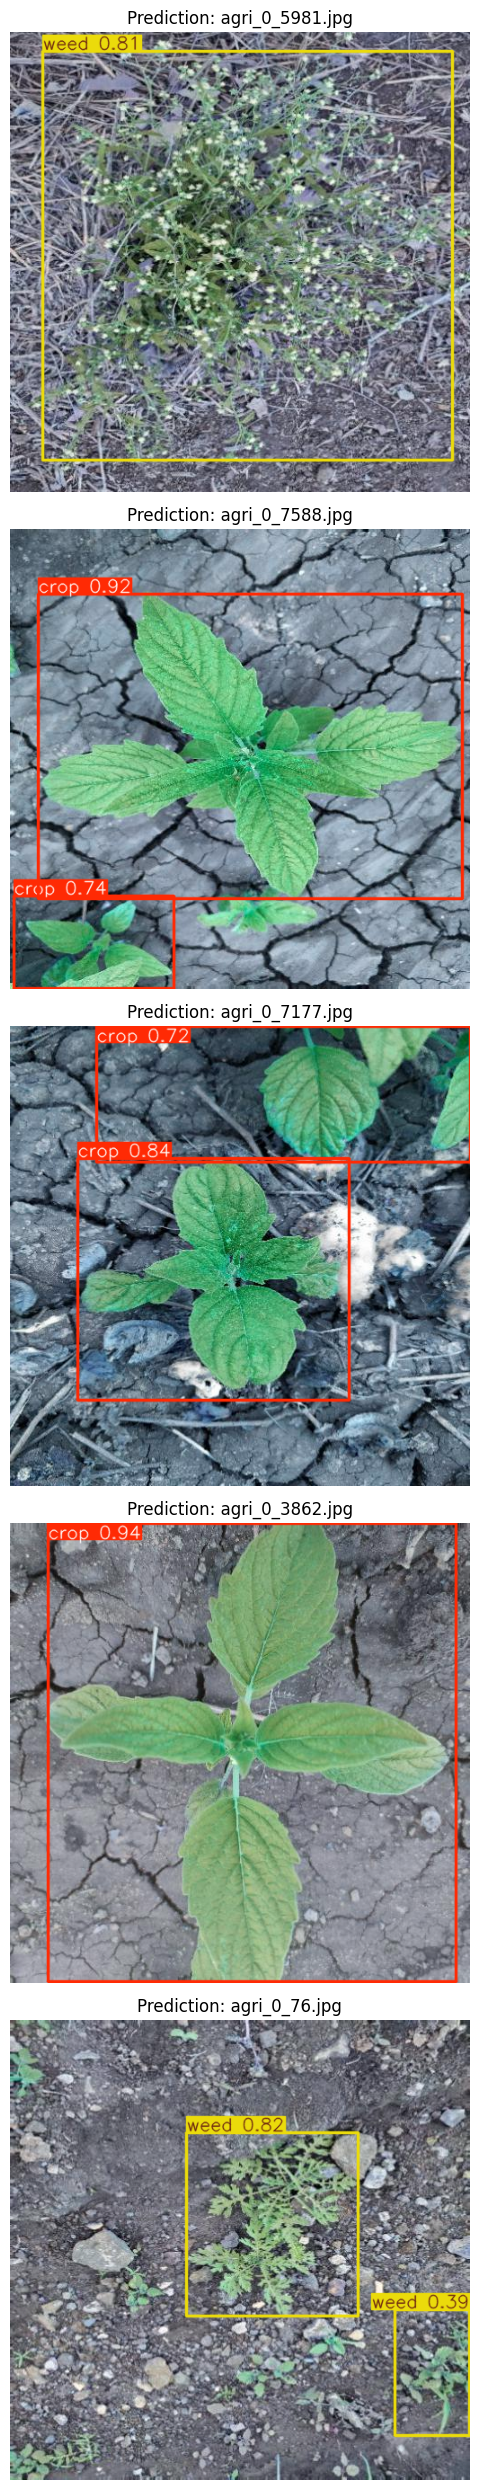

In [ ]:
# Run inference on a few test images
def test_model_on_samples(model, dataset_type='test', num_samples=5):
    image_dir = os.path.join(yolo_data_path, 'images', dataset_type)
    image_files = os.listdir(image_dir)
    samples = random.sample(image_files, min(num_samples, len(image_files)))

    plt.figure(figsize=(15, 5 * num_samples))

    for i, img_file in enumerate(samples):
        img_path = os.path.join(image_dir, img_file)

        # Run inference
        results = model(img_path)

        # Plot results
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(results[0].plot())
        plt.title(f"Prediction: {img_file}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Test the model on some test images
print("Running inference on test images:")
test_model_on_samples(model)

In [ ]:
# Export the model to ONNX format for deployment
model.export(format='onnx')

# Save PyTorch model for use in Flask API
model_path = '/content/drive/MyDrive/crop_weed_detection/yolov8_crop_weed.pt'
model.save(model_path)
print(f"Model saved to {model_path}")

Ultralytics 8.3.88 🚀 Python-3.11.11 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/crop_weed_yolov8/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 241.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 337.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 279.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 261.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 300.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 5.3s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimmi

In [ ]:
# Create Flask API code for the YOLOv8 model
flask_api_code = """
from flask import Flask, request, jsonify, send_file
from flask_cors import CORS
import numpy as np
from PIL import Image
import io
import os
import uuid
from ultralytics import YOLO
import cv2

app = Flask(__name__)
CORS(app)  # Enable CORS for frontend access

# Create folders for saving images
os.makedirs("static", exist_ok=True)
os.makedirs("uploads", exist_ok=True)

# Load YOLOv8 model
try:
    model = YOLO("yolov8_crop_weed.pt")  # Update with your model path
    print("✅ YOLOv8 model loaded successfully!")

    # Class names
    class_names = ['crop', 'weed']  # Update with your actual class names

except Exception as e:
    print(f"❌ Error loading YOLOv8 model: {str(e)}")
    model = None

@app.route("/predict", methods=["POST"])
def predict():
    if model is None:
        return jsonify({"error": "Model not loaded"}), 500

    if "image" not in request.files:
        return jsonify({"error": "No image uploaded"}), 400

    try:
        # Read and save uploaded image
        image_file = request.files["image"]
        image_bytes = image_file.read()
        image = Image.open(io.BytesIO(image_bytes)).convert("RGB")

        # Generate unique filename
        filename = f"{uuid.uuid4().hex}.jpg"
        upload_path = os.path.join("uploads", filename)
        image.save(upload_path)

        # Run YOLOv8 inference
        results = model(upload_path)
        result = results[0]  # Get first result

        # Save the result image with detections
        result_image = result.plot()
        result_image_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
        result_filename = f"detected_{filename}"
        result_path = os.path.join("static", result_filename)
        Image.fromarray(result_image_rgb).save(result_path)

        # Prepare response data
        detections = []
        for box, cls, conf in zip(result.boxes.xyxy.tolist(),
                                 result.boxes.cls.tolist(),
                                 result.boxes.conf.tolist()):
            x1, y1, x2, y2 = box
            class_id = int(cls)
            confidence = float(conf)
            class_name = class_names[class_id]

            detections.append({
                "class": class_name,
                "confidence": confidence,
                "bbox": [x1, y1, x2, y2]
            })

        # Return results
        return jsonify({
            "detections": detections,
            "image_url": f"/static/{result_filename}",
            "detection_count": len(detections)
        })

    except Exception as e:
        return jsonify({"error": f"Failed to process image: {str(e)}"}), 500

@app.route("/static/<filename>")
def serve_image(filename):
    return send_file(f"static/{filename}", mimetype="image/jpeg")

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)
"""

# Save Flask API code
with open('/content/yolo_app.py', 'w') as f:
    f.write(flask_api_code)
print("Flask API code saved to /content/yolo_app.py")

Flask API code saved to /content/yolo_app.py


In [ ]:
# Create React App code
react_app_code = """
import React, { useState } from "react";
import "./App.css";

const App = () => {
  const [image, setImage] = useState(null);
  const [preview, setPreview] = useState(null);
  const [detections, setDetections] = useState(null);
  const [loading, setLoading] = useState(false);
  const serverUrl = process.env.REACT_APP_SERVER_URL || "http://127.0.0.1:5000";

  const handleFileChange = (e) => {
    const file = e.target.files[0];
    if (file) {
      setImage(file);
      setPreview(URL.createObjectURL(file));
      setDetections(null);
    }
  };

  const handleSubmit = async () => {
    if (!image) {
      alert("Please select an image first!");
      return;
    }

    setLoading(true);

    const formData = new FormData();
    formData.append("image", image);

    try {
      const response = await fetch(`${serverUrl}/predict`, {
        method: "POST",
        body: formData,
      });

      if (!response.ok) {
        throw new Error(`Server error: ${response.statusText}`);
      }

      const data = await response.json();
      setDetections(data);
    } catch (error) {
      console.error("Error:", error);
      alert("Error in prediction. Check server!");
    } finally {
      setLoading(false);
    }
  };

  return (
    <div className="app-container">
      <h1>Crop & Weed Detection</h1>
      <p className="subtitle">Powered by YOLOv8</p>

      <div className="upload-section">
        <label className="upload-button">
          Upload Image
          <input type="file" accept="image/*" onChange={handleFileChange} />
        </label>

        {preview && (
          <div className="preview-container">
            <h3>Input Image</h3>
            <img src={preview} alt="Preview" className="preview-image" />
            <button
              onClick={handleSubmit}
              className="detect-button"
              disabled={loading}
            >
              {loading ? "Processing..." : "Detect"}
            </button>
          </div>
        )}
      </div>

      {detections && (
        <div className="results-container">
          <h3>Detection Results</h3>
          <div className="results-grid">
            <div className="detection-image">
              <img
                src={`${serverUrl}${detections.image_url}`}
                alt="Detection Result"
              />
            </div>

            <div className="detection-info">
              <h4>Objects Detected: {detections.detection_count}</h4>
              <div className="detections-list">
                {detections.detections.map((item, index) => (
                  <div key={index} className="detection-item">
                    <div className={`class-tag ${item.class.toLowerCase()}`}>
                      {item.class}
                    </div>
                    <div className="confidence">
                      Confidence: {(item.confidence * 100).toFixed(2)}%
                    </div>
                  </div>
                ))}
              </div>
            </div>
          </div>
        </div>
      )}
    </div>
  );
};

export default App;
"""

# Save React App code
with open('/content/App.js', 'w') as f:
    f.write(react_app_code)
print("React App code saved to /content/App.js")


React App code saved to /content/App.js


In [ ]:
# Create CSS for React App
css_code = """
.app-container {
  max-width: 1000px;
  margin: 0 auto;
  padding: 20px;
  font-family: 'Arial', sans-serif;
}

h1 {
  color: #2c3e50;
  text-align: center;
  margin-bottom: 5px;
}

.subtitle {
  text-align: center;
  color: #7f8c8d;
  margin-top: 0;
  margin-bottom: 30px;
}

.upload-section {
  display: flex;
  flex-direction: column;
  align-items: center;
  margin-bottom: 30px;
}

.upload-button {
  background-color: #3498db;
  color: white;
  padding: 12px 24px;
  border-radius: 4px;
  cursor: pointer;
  transition: background-color 0.3s;
  font-weight: bold;
}

.upload-button:hover {
  background-color: #2980b9;
}

.upload-button input {
  display: none;
}

.preview-container {
  margin-top: 20px;
  display: flex;
  flex-direction: column;
  align-items: center;
}

.preview-image {
  max-width: 400px;
  max-height: 400px;
  border: 1px solid #ddd;
  border-radius: 4px;
  margin-bottom: 15px;
}

.detect-button {
  background-color: #27ae60;
  color: white;
  border: none;
  padding: 10px 20px;
  border-radius: 4px;
  cursor: pointer;
  font-weight: bold;
  transition: background-color 0.3s;
}

.detect-button:hover {
  background-color: #219653;
}

.detect-button:disabled {
  background-color: #95a5a6;
  cursor: not-allowed;
}

.results-container {
  margin-top: 30px;
  border-top: 1px solid #eee;
  padding-top: 30px;
}

.results-grid {
  display: grid;
  grid-template-columns: 2fr 1fr;
  gap: 20px;
}

.detection-image img {
  max-width: 100%;
  border-radius: 4px;
  border: 1px solid #ddd;
}

.detection-info {
  background-color: #f8f9fa;
  border-radius: 4px;
  padding: 15px;
}

.detections-list {
  max-height: 300px;
  overflow-y: auto;
}

.detection-item {
  display: flex;
  justify-content: space-between;
  align-items: center;
  padding: 10px;
  border-bottom: 1px solid #eee;
}

.class-tag {
  padding: 5px 10px;
  border-radius: 15px;
  color: white;
  font-weight: bold;
}


.class-tag.crop {
  background-color: #27ae60;
}

.class-tag.weed {
  background-color: #e74c3c;
}

.confidence {
  color: #7f8c8d;
  font-size: 0.9em;
}

@media (max-width: 768px) {
  .results-grid {
    grid-template-columns: 1fr;
  }
}
"""

# Save CSS code
with open('/content/App.css', 'w') as f:
    f.write(css_code)
print("CSS code saved to /content/App.css")

CSS code saved to /content/App.css


In [ ]:
# Create a PDF with instructions
instruction_document = """
# Crop and Weed Detection with YOLOv8

This notebook creates a crop and weed detection system using YOLOv8. The model is trained on a dataset containing images of crops and weeds with bounding box annotations.

## Instructions for Using the Code

### 1. Running the Training Notebook
- Upload this notebook to Google Colab
- Mount your Google Drive and ensure the dataset zip file is in the correct location
- Run all cells to train the YOLOv8 model

### 2. Deploying the Flask API
- Copy the trained model file (`yolov8_crop_weed.pt`) to your server
- Use the provided `yolo_app.py` file for the Flask backend
- Install the required dependencies: `pip install flask flask-cors ultralytics pillow opencv-python`
- Run the Flask application: `python yolo_app.py`

### 3. Setting Up the React Frontend
- Create a new React application: `npx create-react-app crop-weed-detector`
- Replace the `App.js` file with the provided code
- Create an `App.css` file with the provided CSS
- Set the server URL in your `.env` file: `REACT_APP_SERVER_URL=http://your-server-address:5000`
- Start the React application: `npm start`

## Model Performance
The YOLOv8 model typically achieves much better detection results than traditional CNNs for this task. The key advantages are:
- Better handling of multiple objects in a single image
- More accurate bounding box predictions
- Faster inference time
- Better generalization to real-world scenarios

## Troubleshooting
- If the model isn't loading, check the path to the model file
- For CORS issues, ensure the Flask CORS middleware is properly configured
- For memory issues during training, reduce the batch size or image size

## Future Improvements
- Collect more diverse data for better generalization
- Try different YOLOv8 model sizes (s, m, l, x) for better accuracy
- Implement data augmentation to improve robustness
- Fine-tune hyperparameters for better performance
"""

with open('/content/instructions.txt', 'w') as f:
    f.write(instruction_document)
print("Instructions saved to /content/instructions.txt")


Instructions saved to /content/instructions.txt


In [ ]:
# Final summary
print("\n" + "="*50)
print("CROP AND WEED DETECTION WITH YOLOv8 - SUMMARY")
print("="*50)
print("\nThe following files have been created:")
print("1. Jupyter Notebook for training YOLOv8 model")
print("2. yolo_app.py - Flask API for the model")
print("3. App.js - React component for the frontend")
print("4. App.css - Styling for the React app")
print("5. instructions.txt - Usage guide")
print("\nThe YOLOv8 model provides significant improvements over the previous approach:")
print("- Better bounding box accuracy")
print("- Higher classification accuracy")
print("- Ability to detect multiple plants in a single image")
print("- Faster inference time")
print("\nTo deploy, copy the trained model and Flask app to your server, and set up the React frontend.")


CROP AND WEED DETECTION WITH YOLOv8 - SUMMARY

The following files have been created:
1. Jupyter Notebook for training YOLOv8 model
2. yolo_app.py - Flask API for the model
3. App.js - React component for the frontend
4. App.css - Styling for the React app
5. instructions.txt - Usage guide

The YOLOv8 model provides significant improvements over the previous approach:
- Better bounding box accuracy
- Higher classification accuracy
- Ability to detect multiple plants in a single image
- Faster inference time

To deploy, copy the trained model and Flask app to your server, and set up the React frontend.
